In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoConfig, CvtForImageClassification, AutoImageProcessor
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
import os
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import random

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
BATCH_SIZE = 16
NUM_CLASSES = 20
EPOCHS = 100
LEARNING_RATE = 0.00015836211715780283
WEIGHT_DECAY = 0.00002683
IMAGE_SIZE = 224
DATASET_PATH = '/kaggle/input/d/phiard/aksara-jawa/v3/v3'  # Pastikan path ini benar

In [4]:
config = AutoConfig.from_pretrained("microsoft/cvt-13")
config.num_labels = NUM_CLASSES
config.hidden_dropout_prob = 0.25416416873049263

model = CvtForImageClassification.from_pretrained(
    "microsoft/cvt-13", config=config, ignore_mismatched_sizes=True
).to(device)

config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([20, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Transformasi untuk data pelatihan dengan augmentasi
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # Flipping horizontal acak
    transforms.RandomRotation(20),                # Rotasi acak antara -20 hingga 20 derajat
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # Crop acak dengan ukuran tertentu
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variasi warna
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisasi
])

# Transformasi untuk data validasi tanpa augmentasi
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),               # Resize gambar untuk validasi
    transforms.CenterCrop(IMAGE_SIZE),           # Crop di tengah
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisasi
])


In [6]:
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(root)
        self.num_classes = len(self.classes)

        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root_, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root_, fname)
                    try:
                        with Image.open(path) as img:
                            img.verify()  # Verifikasi integritas gambar
                        self.samples.append((path, class_index))
                        self.targets.append(class_index)
                    except (UnidentifiedImageError, OSError):
                        print(f"Gambar korup dilewati: {path}")
                        continue

    def __getitem__(self, index):
        path, target = self.samples[index]
        with Image.open(path) as sample:
            sample = sample.convert('RGB')
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, target

    def __len__(self):
        return len(self.samples)

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx


In [7]:
train_dir = os.path.join(DATASET_PATH, 'train')
val_dir = os.path.join(DATASET_PATH, 'val')

# Membuat dataset dengan transformasi yang sesuai
train_dataset = CustomImageFolder(train_dir, transform=train_transform)
val_dataset = CustomImageFolder(val_dir, transform=val_transform)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets),
    y=train_dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [10]:
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)


In [11]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

In [12]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).logits
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data).logits
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    return total_loss / len(loader), 100. * correct / total, f1, all_targets, all_predictions


In [15]:
writer = SummaryWriter()
train_losses = []
train_accs = []
val_losses = []
val_accs = []
val_f1_scores = []
patience = 10  # Jumlah epoch tanpa peningkatan sebelum berhenti
counter = 0
best_val_acc = 0


for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, all_targets, all_predictions = validate(model, val_loader, criterion)
    
    # Menyimpan metrik
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1_scores.append(val_f1)

    # Logging ke TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)
    writer.add_scalar('F1_Score/Val', val_f1, epoch)

    # Menyimpan model terbaik
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cvt_model.pth")
        counter = 0  # Reset counter jika ada peningkatan
    else:
        counter += 1

    # Early stopping
    if counter >= patience:
        print(f"Early stopping setelah epoch {epoch+1} karena tidak ada peningkatan akurasi validasi.")
        break

    # Menampilkan progres
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1 Score: {val_f1:.4f}")

    # Update scheduler
    scheduler.step()

writer.close()


Epoch 1/100
Train Loss: 2.7283, Train Acc: 17.78%
Val Loss: 1.8613, Val Acc: 38.12%, Val F1 Score: 0.3320


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/100
Train Loss: 1.5365, Train Acc: 59.94%
Val Loss: 0.7900, Val Acc: 83.96%, Val F1 Score: 0.8340


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/100
Train Loss: 1.0703, Train Acc: 74.74%
Val Loss: 0.5850, Val Acc: 91.46%, Val F1 Score: 0.9161


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/100
Train Loss: 0.9988, Train Acc: 76.51%
Val Loss: 0.5857, Val Acc: 90.62%, Val F1 Score: 0.8946


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/100
Train Loss: 0.9774, Train Acc: 77.16%
Val Loss: 0.5316, Val Acc: 92.08%, Val F1 Score: 0.9194


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/100
Train Loss: 0.9178, Train Acc: 78.74%
Val Loss: 0.5527, Val Acc: 92.08%, Val F1 Score: 0.9199


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/100
Train Loss: 0.9005, Train Acc: 79.48%
Val Loss: 0.5612, Val Acc: 92.08%, Val F1 Score: 0.9204


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/100
Train Loss: 0.9202, Train Acc: 79.71%
Val Loss: 0.5910, Val Acc: 92.29%, Val F1 Score: 0.9221


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/100
Train Loss: 0.8953, Train Acc: 80.18%
Val Loss: 0.5987, Val Acc: 92.50%, Val F1 Score: 0.9222


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/100
Train Loss: 0.8971, Train Acc: 80.13%
Val Loss: 0.5897, Val Acc: 92.71%, Val F1 Score: 0.9254


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/100
Train Loss: 0.9181, Train Acc: 79.16%
Val Loss: 0.5856, Val Acc: 92.71%, Val F1 Score: 0.9254


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/100
Train Loss: 0.8773, Train Acc: 80.64%
Val Loss: 0.5850, Val Acc: 92.50%, Val F1 Score: 0.9235


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/100
Train Loss: 0.8406, Train Acc: 82.27%
Val Loss: 0.6116, Val Acc: 92.29%, Val F1 Score: 0.9202


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/100
Train Loss: 0.9019, Train Acc: 79.76%
Val Loss: 0.5896, Val Acc: 93.54%, Val F1 Score: 0.9352


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/100
Train Loss: 0.8963, Train Acc: 79.90%
Val Loss: 0.6763, Val Acc: 90.00%, Val F1 Score: 0.8968


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/100
Train Loss: 0.9309, Train Acc: 78.18%
Val Loss: 0.5923, Val Acc: 91.25%, Val F1 Score: 0.9088


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/100
Train Loss: 0.9626, Train Acc: 77.90%
Val Loss: 0.5683, Val Acc: 92.08%, Val F1 Score: 0.9178


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/100
Train Loss: 0.9484, Train Acc: 78.32%
Val Loss: 0.5804, Val Acc: 93.12%, Val F1 Score: 0.9117


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/100
Train Loss: 0.8995, Train Acc: 79.94%
Val Loss: 0.5493, Val Acc: 92.50%, Val F1 Score: 0.9160


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/100
Train Loss: 0.9639, Train Acc: 77.30%
Val Loss: 0.7335, Val Acc: 87.29%, Val F1 Score: 0.8571


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 21/100
Train Loss: 0.9556, Train Acc: 77.81%
Val Loss: 0.6892, Val Acc: 85.62%, Val F1 Score: 0.8523


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 22/100
Train Loss: 0.9235, Train Acc: 79.29%
Val Loss: 0.6292, Val Acc: 89.58%, Val F1 Score: 0.8874


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 23/100
Train Loss: 0.9029, Train Acc: 79.67%
Val Loss: 0.6285, Val Acc: 91.25%, Val F1 Score: 0.9125


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Early stopping setelah epoch 24 karena tidak ada peningkatan akurasi validasi.


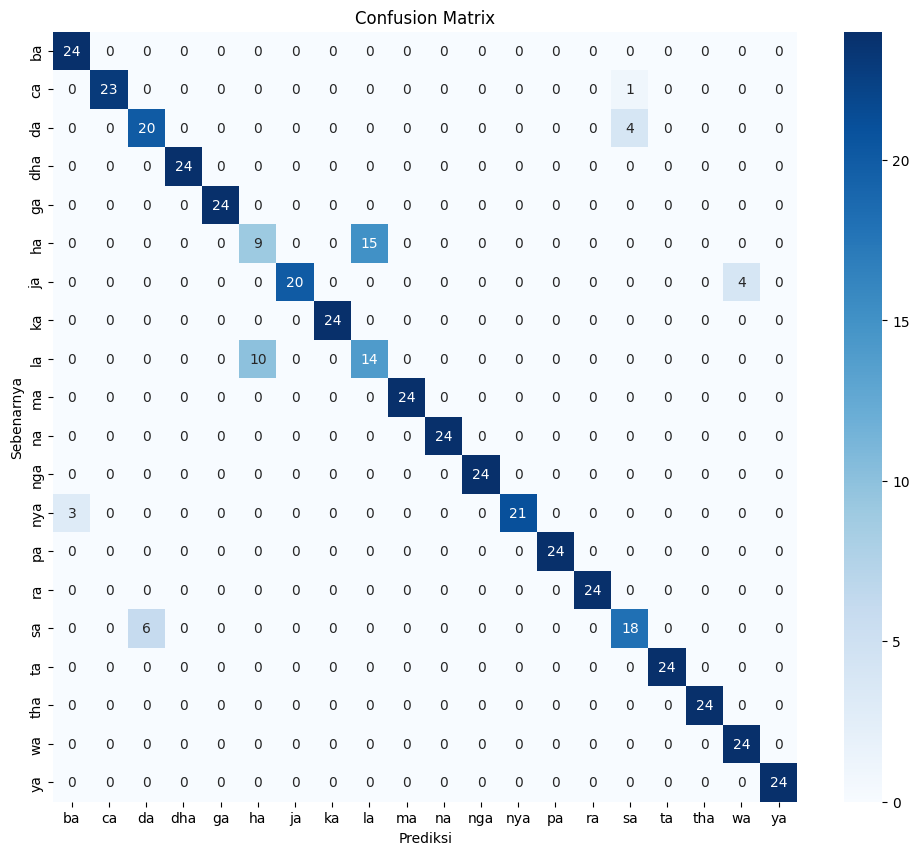

In [16]:
def plot_confusion_matrix(targets, predictions, class_names):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Prediksi")
    plt.ylabel("Sebenarnya")
    plt.title("Confusion Matrix")
    plt.show()

# Pastikan 'all_targets' dan 'all_predictions' berasal dari epoch terakhir validasi
plot_confusion_matrix(all_targets, all_predictions, train_dataset.classes)


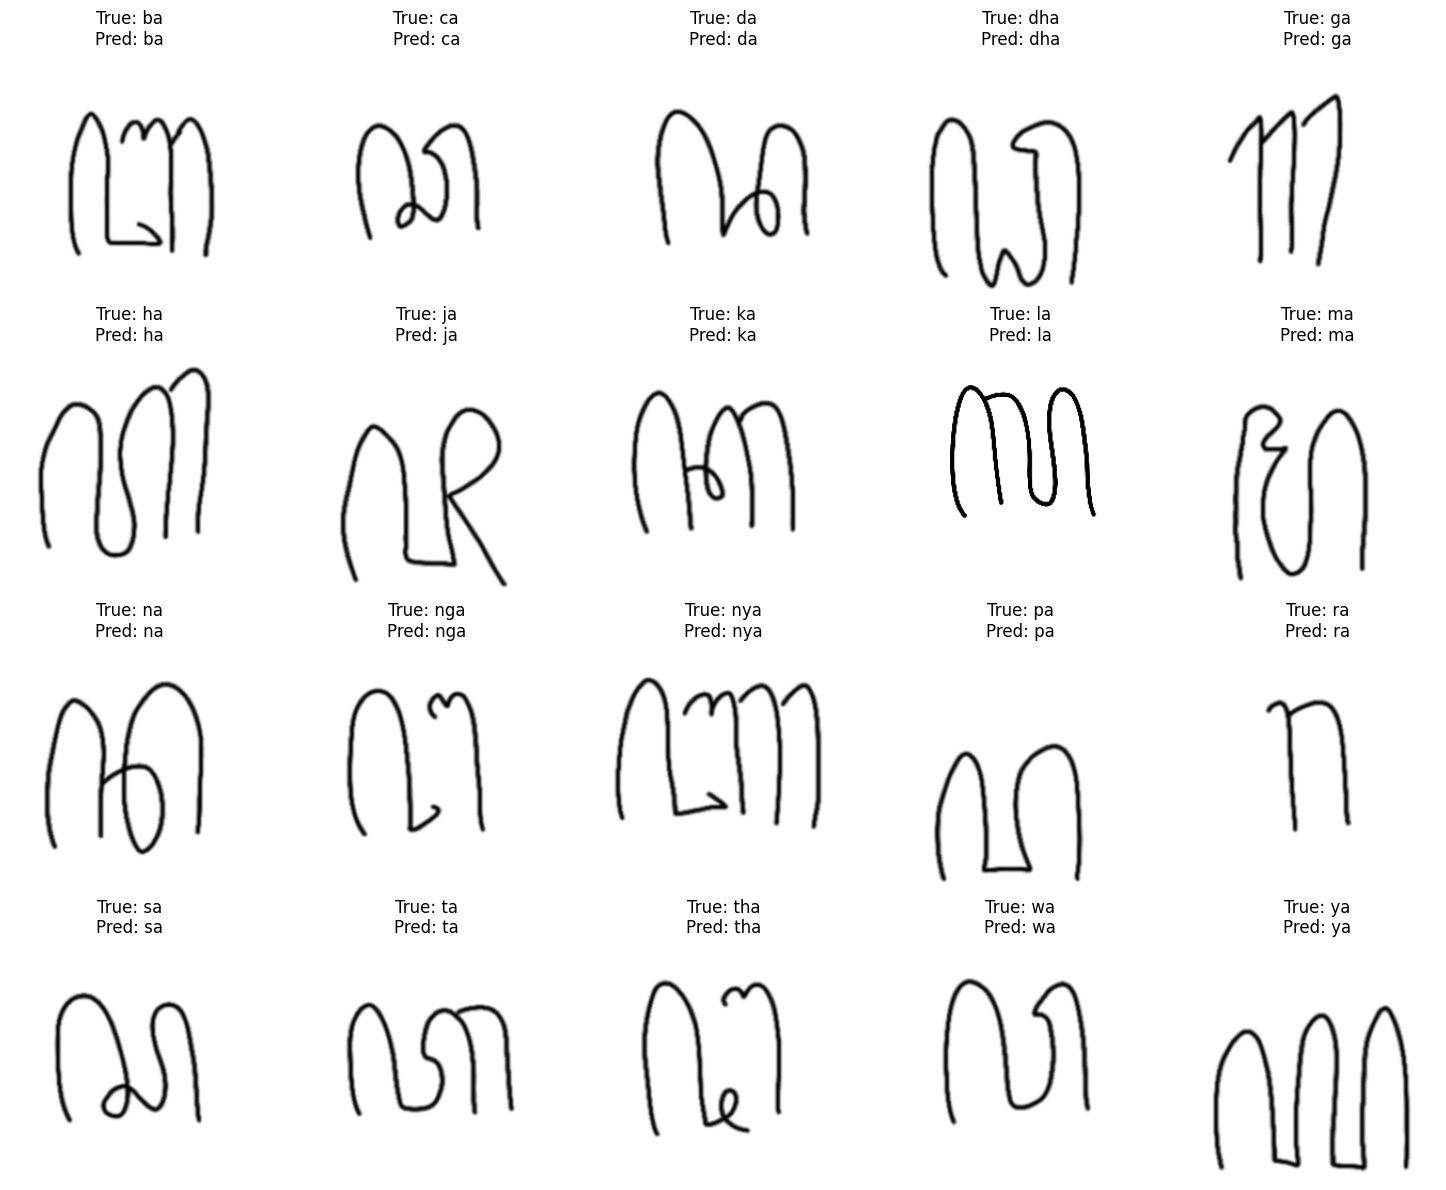

In [17]:
def show_predictions_per_class(model, dataset, num_classes=20, cols=5):
    model.eval()
    rows = (num_classes + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axs = axs.flatten()

    class_images = {i: None for i in range(num_classes)}

    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image).logits
            _, predicted = output.max(1)
            if class_images[label] is None and predicted.item() == label:
                class_images[label] = (image.squeeze().cpu(), label, predicted.item())
                if all(value is not None for value in class_images.values()):
                    break

    for i in range(num_classes):
        ax = axs[i]
        if class_images[i] is not None:
            img, true_label, pred_label = class_images[i]
            # Denormalisasi gambar
            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(f"True: {train_dataset.classes[true_label]}\nPred: {train_dataset.classes[pred_label]}")
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, 'No Prediction', ha='center', va='center')
            ax.axis('off')

    for j in range(num_classes, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Tampilkan prediksi per kelas
show_predictions_per_class(model, val_dataset)


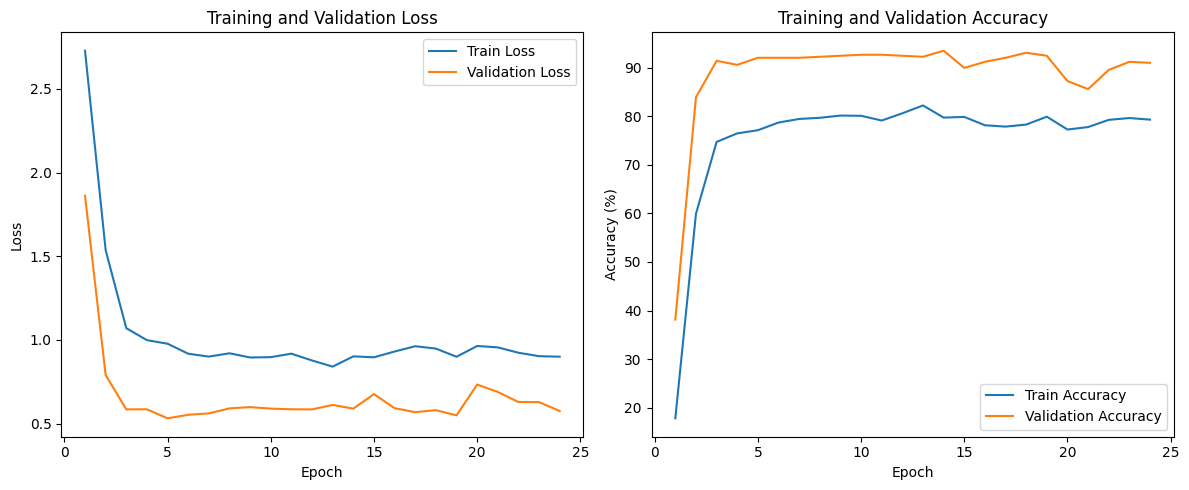

In [18]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
